In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.graphics.gofplots import qqplot
from scipy import stats
import seaborn as sns

In [3]:
df = pd.read_excel('Projekt-2_Data.xlsx', sheet_name='Úloha 2')

In [4]:
df

,OSType,ActiveUsers,InteractingPct,ScrollingPct,Ping [ms]
0,iOS,4113,0.8283,0.1717,47
1,iOS,7549,0.3461,0.6539,46
2,Windows,8855,0.2178,0.7822,55
3,Android,8870,0.0794,0.9206,56
4,MacOS,9559,0.7282,0.2718,76
...,...,...,...,...,...
497,iOS,5315,0.1974,0.8026,28
498,MacOS,1392,0.2373,0.7627,24
499,iOS,6014,0.8112,0.1888,54
500,Android,5118,0.2345,0.7655,39


In [5]:
# rename columns
df.rename(columns=
    {"ActiveUsers": "users", 
    "ScrollingPct": "scroll", 
    "Ping [ms]": "ping", 
    "InteractingPct": "inter", 
    "OSType":"os"}, inplace=True)
# normalize users column to range 0-1
df["users"] = (df["users"] - df["users"].min()) / (df["users"].max() - df["users"].min())
# df['users'] = df['users']=(df['users'] - df['users'].mean()) / df['users'].std()
df

,os,users,inter,scroll,ping
0,iOS,0.404082,0.8283,0.1717,47
1,iOS,0.754694,0.3461,0.6539,46
2,Windows,0.887959,0.2178,0.7822,55
3,Android,0.889490,0.0794,0.9206,56
4,MacOS,0.959796,0.7282,0.2718,76
...,...,...,...,...,...
497,iOS,0.526735,0.1974,0.8026,28
498,MacOS,0.126429,0.2373,0.7627,24
499,iOS,0.598061,0.8112,0.1888,54
500,Android,0.506633,0.2345,0.7655,39


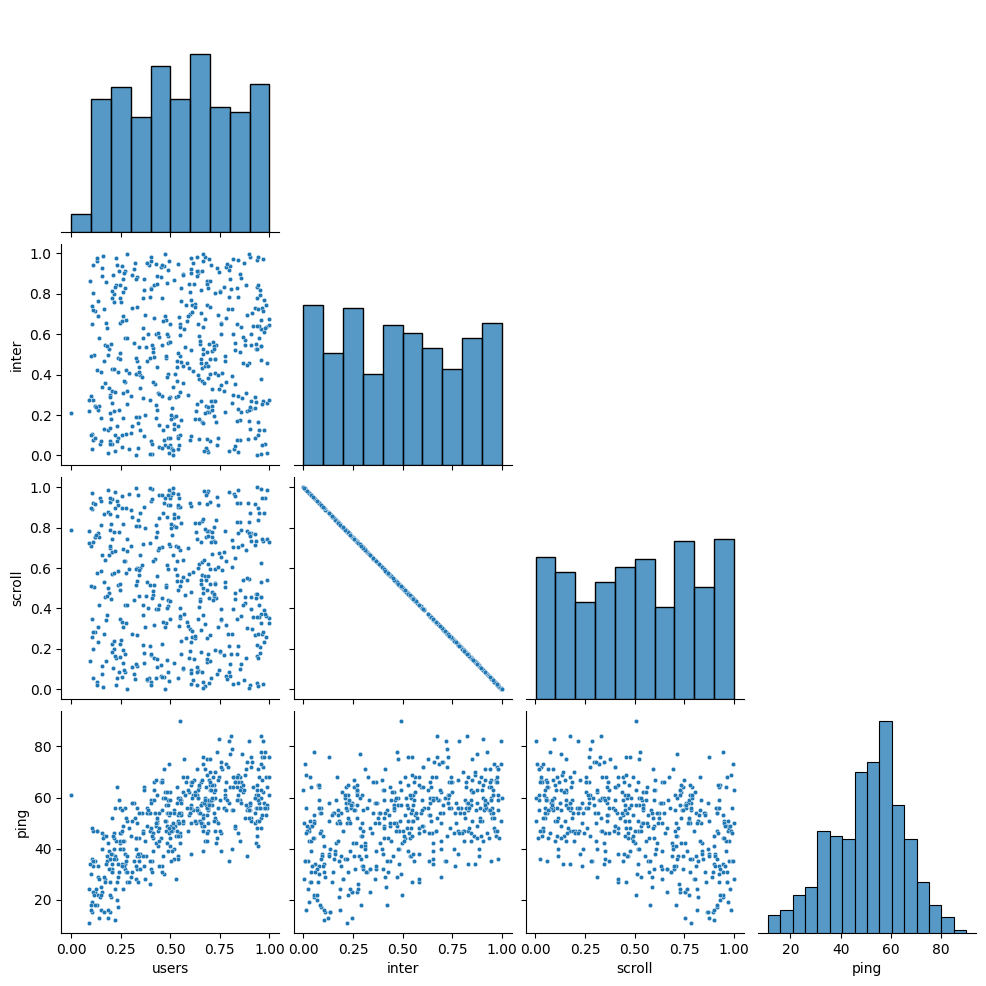

In [6]:
pp = sns.pairplot(df, corner=True, plot_kws={"s": 10})
pp.savefig("pairplot.png")

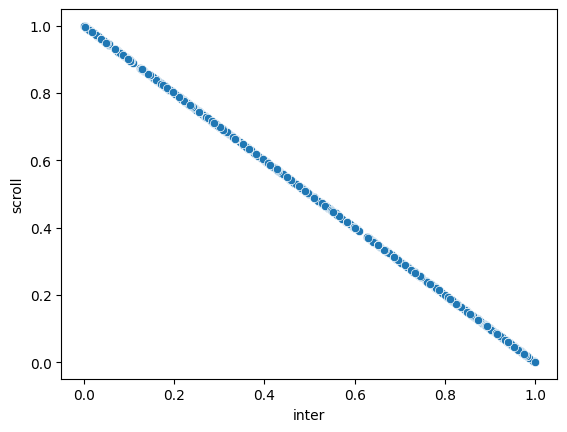

In [7]:
sp = sns.scatterplot(data=df, x="inter", y="scroll")
sp.get_figure().savefig("scatterplot.png")

In [8]:
def print_everything():
    global model
    X = pd.DataFrame(model.exog, columns=model.exog_names)
    vif = pd.Series([variance_inflation_factor(X.values, i) 
                    for i in range(X.shape[1])], 
                    index=X.columns)
    vif_df = vif.to_frame()
    # Nastavení názvu sloupce
    vif_df.columns = ['VIF']
    print('\n\n\n')
    print(vif_df)
    #ukaž korelaci prediktorů
    print('\n\n\n')
    print(X.corr())

In [9]:
# start from full quadratic model and remove insignificant variables
# we can omit 'interactions' as they are colinear with 'scrolling'

UsersInt  = '+ users*scroll + users*C(os) '
ScrollInt = '+ scroll*C(os) '
Quadratic = '+ I(users**2) + I(scroll**2) '
formula = 'ping ~ users + scroll + C(os) ' + UsersInt + ScrollInt + Quadratic

model=smf.ols(formula=formula, data=df)
results=model.fit()
print(results.summary())

print_everything()

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     187.9
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          5.18e-186
Time:                        15:51:41   Log-Likelihood:                -1598.4
No. Observations:                 502   AIC:                             3227.
Df Residuals:                     487   BIC:                             3290.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## First iteration:
- the highest p-value has the categorical value, but only some parts of it so we can not exclude it
- we can try to do separate F-test on the category as a whole

In [10]:
hypothesis='(C(os)[T.MacOS]=0),(C(os)[T.iOS]=0),(C(os)[T.Windows]=0)' # ak chceme testovat kategorialnu premennu ako celok = separatny Ftest
F_test=results.f_test(hypothesis)
print(F_test)

<F test: F=5.63101840736676, p=0.0008445351034798086, df_denom=487, df_num=3>


In [11]:
hypothesis='(scroll:C(os)[T.MacOS]=0),(scroll:C(os)[T.iOS]=0),(scroll:C(os)[T.Windows]=0)' # ak chceme testovat kategorialnu premennu ako celok = separatny Ftest
F_test=results.f_test(hypothesis)
print(F_test)

<F test: F=0.039265795268086094, p=0.9896055446986147, df_denom=487, df_num=3>


- the whole category is not redundant as a result of the F-test
- we can remove the first interaction between s and o, since for all values the p-value is greater than 0.05

In [12]:
# after deleting s*C(o)
UsersInt  = '+ users*scroll + users*C(os) '
Quadratic = '+ I(users**2) + I(scroll**2) '
formula = 'ping ~ users + scroll + C(os) ' + UsersInt + Quadratic

model=smf.ols(formula=formula, data=df) # přepiš původní (lineární) model
results=model.fit()
print(results.summary())
print_everything()

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     240.6
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.57e-189
Time:                        15:51:41   Log-Likelihood:                -1598.5
No. Observations:                 502   AIC:                             3221.
Df Residuals:                     490   BIC:                             3272.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 34

# Second iteration
- the next high p-valued predictor is I(s ** 2) so we can remove it

In [13]:
UsersInt  = '+ users*scroll + users*C(os) '
Quadratic = '+ I(users**2) '
formula = 'ping ~ users + scroll + C(os) ' + UsersInt + Quadratic


model=smf.ols(formula=formula, data=df) # přepiš původní (lineární) model
results=model.fit()
print(results.summary())
print_everything()

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     264.4
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          1.69e-190
Time:                        15:51:41   Log-Likelihood:                -1599.1
No. Observations:                 502   AIC:                             3220.
Df Residuals:                     491   BIC:                             3267.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 35

# Removing more predictors based on VIF

We can see in VIF that the users and users ** 2 predictor is high ... We can try to remove the quadratic predictor and see, that the overall performance does not drop dramatically, conditional number drops as well

In [14]:
FOU  = '+ users*scroll + users*C(os) '
formula = 'ping ~ users + scroll + C(os) ' + FOU


model=smf.ols(formula=formula, data=df) # přepiš původní (lineární) model
results=model.fit()
print(results.summary())
print_everything()

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     240.4
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          7.74e-174
Time:                        15:51:41   Log-Likelihood:                -1641.3
No. Observations:                 502   AIC:                             3303.
Df Residuals:                     492   BIC:                             3345.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 46

After experimenting abit I found out, that we can also drop predictor with users and keep only their interactions, which does not change the accuracy and drops the VIF values even lower

In [15]:
FOU  = '+ users:scroll + users:C(os) '
formula = 'ping ~ scroll + C(os) ' + FOU


model=smf.ols(formula=formula, data=df) # přepiš původní (lineární) model
results=model.fit()
print(results.summary())
print_everything()

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     240.4
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          7.74e-174
Time:                        15:51:41   Log-Likelihood:                -1641.3
No. Observations:                 502   AIC:                             3303.
Df Residuals:                     492   BIC:                             3345.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               46.0894 

## Diagnostics


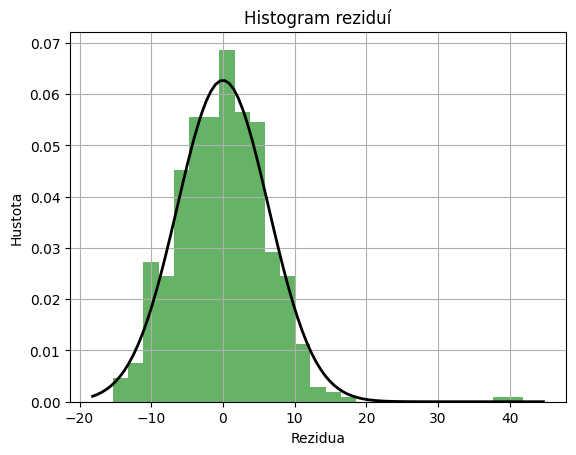

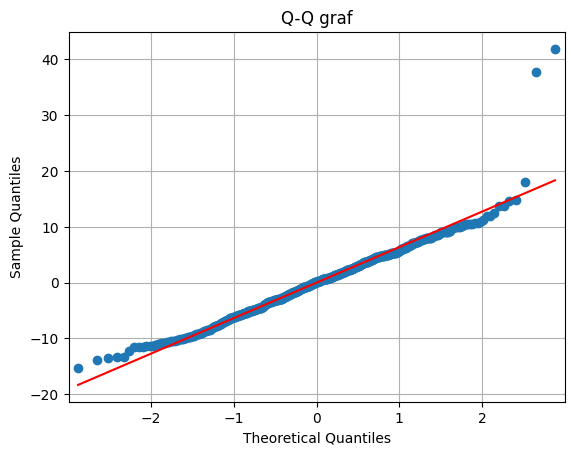

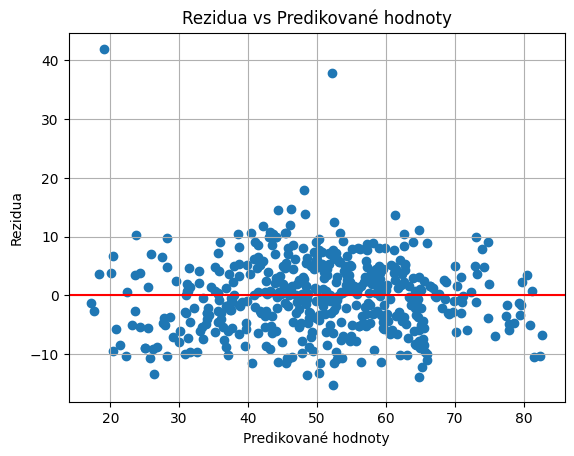

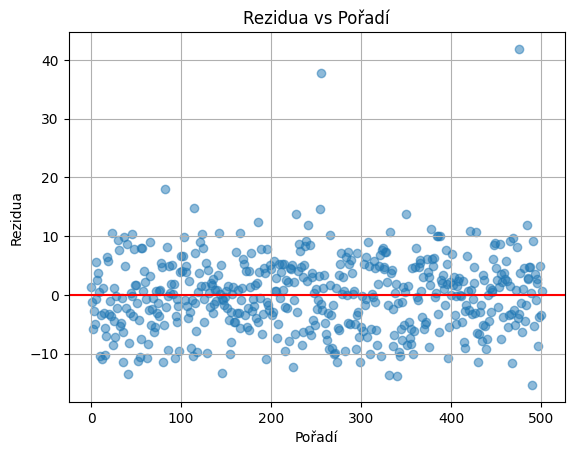

In [16]:
# Vykreslení histogramu reziduí - pro málo pozorování moc nedává smysl
plt.hist(results.resid, bins='auto', density=True, alpha=0.6, color='g')

# Vykreslení odpovídající Gaussovy křivky
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(results.resid), np.std(results.resid))
plt.plot(x, p, 'k', linewidth=2)
plt.grid(True)
plt.title("Histogram reziduí")
plt.xlabel("Rezidua")
plt.ylabel("Hustota")

plt.show()
#q-q plot
qqplot(results.resid, line='s')
plt.title('Q-Q graf')
plt.grid(True)
plt.show()

#res vs fit
plt.scatter(results.fittedvalues, results.resid)
plt.axhline(y=0, color='r', linestyle='-') 
plt.grid(True)
plt.xlabel('Predikované hodnoty')
plt.ylabel('Rezidua')
plt.title('Rezidua vs Predikované hodnoty')
plt.show()

# res vs order
plt.scatter(range(len(results.resid)), results.resid, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-') 
plt.grid(True)
plt.title("Rezidua vs Pořadí")
plt.xlabel("Pořadí")
plt.ylabel("Rezidua")

plt.show()

We can see that there are 2 outliers being present in the data based on diagnostic graphs

In [17]:
influence = results.get_influence()
outl_stats_df = pd.DataFrame({
    'Standardized Residuals': influence.resid_studentized_internal,
}, index=df.index)
outl_stats_df = outl_stats_df[(np.abs(outl_stats_df['Standardized Residuals']) > 2)]

print(outl_stats_df)

     Standardized Residuals
41                -2.124889
82                 2.804205
114                2.307562
145               -2.086569
228                2.156335
254                2.280221
255                5.902586
331               -2.159472
340               -2.185123
350                2.140092
476                6.692070
490               -2.414277


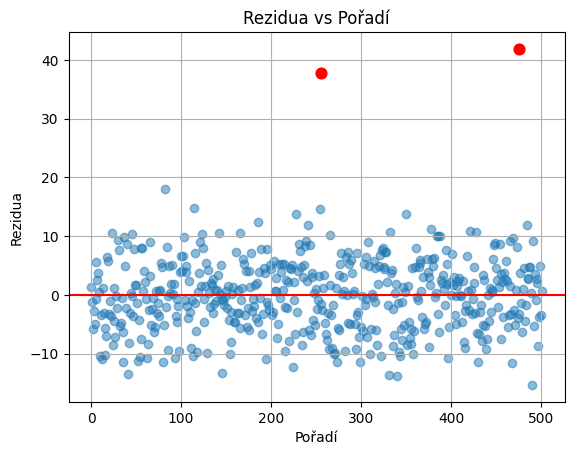

In [18]:
# Showing werid values in plot
index = [255, 476]

plt.scatter(range(len(results.resid)), results.resid, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='-') 
plt.grid(True)
plt.title("Rezidua vs Pořadí")
plt.xlabel("Pořadí")
plt.ylabel("Rezidua")

plt.scatter(index, results.resid[index], color='r', s=60)
plt.savefig("residuals.png")


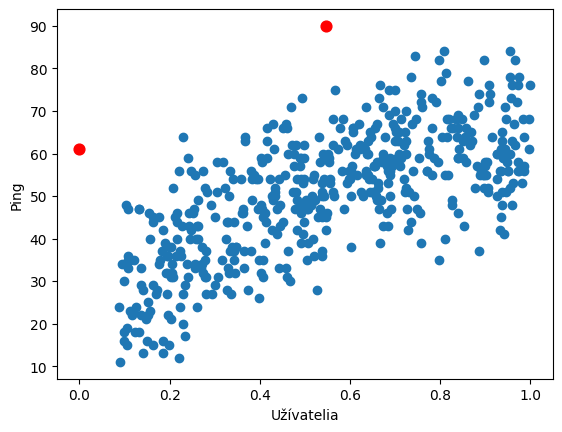

In [19]:
# Showing values with index 255 and 476 on users vs ping plot
idx = [255, 476]
plt.scatter(df.users, df.ping)
plt.scatter(df.users[idx], df.ping[idx], color='r', s=60)
plt.xlabel("Užívatelia")
plt.ylabel("Ping")
plt.savefig("users_vs_ping.png")

In [20]:
# dropping outliers
df = df.drop(idx)

In [21]:
FOU  = '+ users:scroll + users:C(os) '
formula = 'ping ~ scroll + C(os) ' + FOU

formula

model=smf.ols(formula=formula, data=df) # přepiš původní (lineární) model
results=model.fit()
print(results.summary())
print_everything()

                            OLS Regression Results                            
Dep. Variable:                   ping   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     290.8
Date:                Sat, 16 Dec 2023   Prob (F-statistic):          3.35e-190
Time:                        15:51:43   Log-Likelihood:                -1591.6
No. Observations:                 500   AIC:                             3203.
Df Residuals:                     490   BIC:                             3245.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               46.9796 

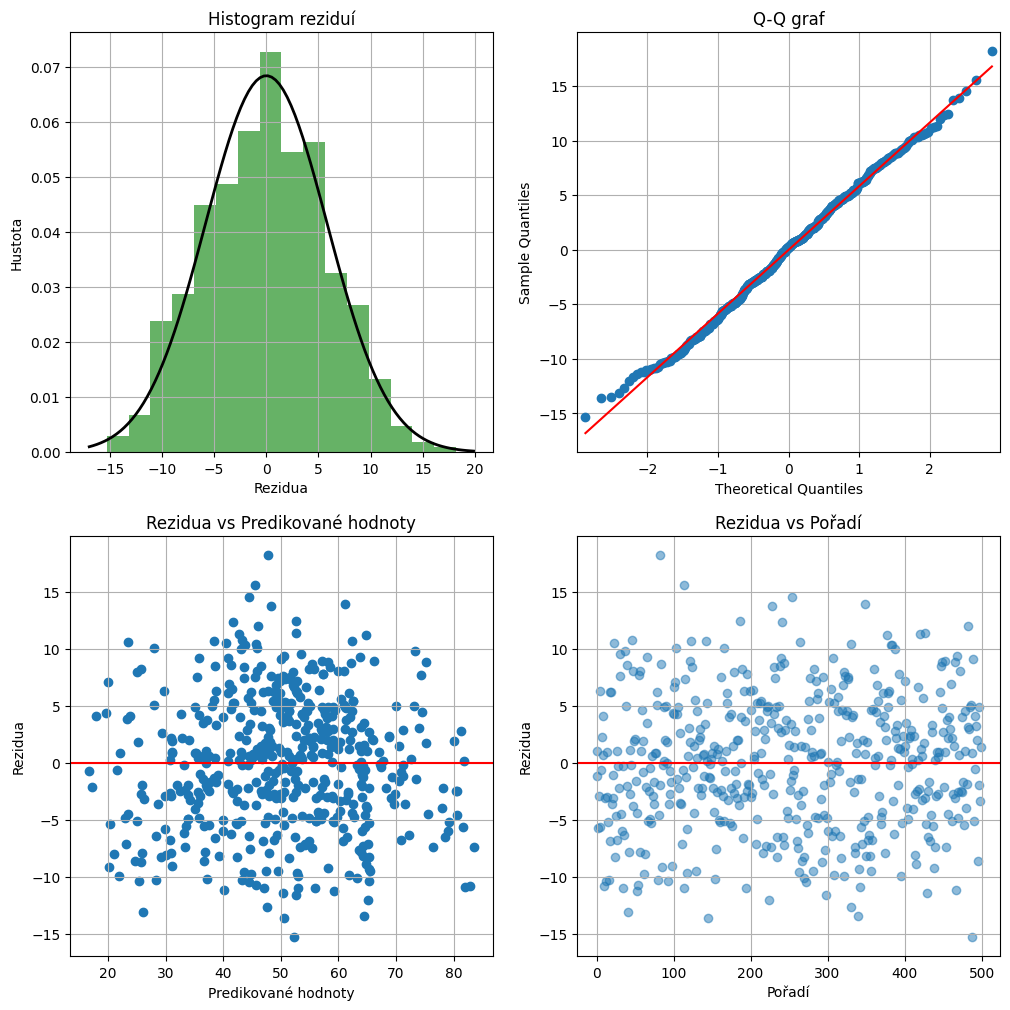

In [22]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12,12))

# Vykreslení histogramu reziduí - pro málo pozorování moc nedává smysl
ax1.hist(results.resid, bins='auto', density=True, alpha=0.6, color='g')


# Vykreslení odpovídající Gaussovy křivky
xmin, xmax, _, _ = ax1.axis()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, np.mean(results.resid), np.std(results.resid))
ax1.plot(x, p, 'k', linewidth=2)
ax1.grid(True)
ax1.set_title("Histogram reziduí")
ax1.set_xlabel("Rezidua")
ax1.set_ylabel("Hustota")

#q-q plot
qqplot(results.resid, line='s', ax=ax2)
ax2.set_title('Q-Q graf')
ax2.grid(True)

#res vs fit
ax3.scatter(results.fittedvalues, results.resid)
ax3.axhline(y=0, color='r', linestyle='-') 
ax3.grid(True)
ax3.set_xlabel('Predikované hodnoty')
ax3.set_ylabel('Rezidua')
ax3.set_title('Rezidua vs Predikované hodnoty')

# res vs order
ax4.scatter(range(len(results.resid)), results.resid, alpha=0.5)
ax4.axhline(y=0, color='r', linestyle='-') 
ax4.grid(True)
ax4.set_title("Rezidua vs Pořadí")
ax4.set_xlabel("Pořadí")
ax4.set_ylabel("Rezidua")

fig.savefig("diagnostics.png")

In [23]:
# results.resid
model.exog
# np.linalg.det(model.exog.T)
# np.linalg.matrix_rank(model.exog) < model.endog.size
np.linalg.matrix_rank(model.exog)

10

In [31]:
max_ping = results.predict().argmax()
results.predict()[max_ping]

16.737362603817722

In [33]:
# test = df.iloc[0:1]
# test

# test["os"] = "MacOS"
# test["users"] = df["users"].mean()
# test["scroll"] = df["scroll"].mean()

# input_val = pd.DataFrame({
#     "os": ["Windows"], "users": [df["users"].mean()], "scroll": [df["scroll"].mean()]})
# pred = results.get_prediction(input_val)
# pred.summary_frame(alpha=0.05)

# theoretical maximum ping
test = pd.DataFrame({"os": ["MacOS"], "users": [1], "scroll": [0]})
pred = results.get_prediction(test)
pred.summary_frame(alpha=0.05)

# mean - konfidencni interval
# obs - predikcni interval

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,84.090313,1.355015,81.427957,86.752669,72.202204,95.978422
